<a href="https://colab.research.google.com/github/SumaiyaZohaRODELA/GAN_selfstudy/blob/main/GAN_self_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Step 2: Defining Image Transformations

In [ ]:
# Define a basic transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Step 3: Loading the CIFAR-10 Dataset

The CIFAR-10 dataset is loaded with predefined transformations. A DataLoader is created to process the dataset in mini-batches of 32 images, shuffled for randomness.


In [ ]:
train_dataset = datasets.CIFAR10(root='./data',\
              train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
                                batch_size=32, shuffle=True)

100%|██████████| 170M/170M [00:03<00:00, 53.9MB/s]


Step 4: Defining GAN Hyperparameters
Key hyperparameters are defined:

latent_dim – Dimensionality of the noise vector.
lr – Learning rate of the optimizer.
beta1, beta2 – Adam optimizer coefficients.
num_epochs – Total training iterations.

In [ ]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10

Step 5: Building the Generator
The generator takes a random latent vector (z) as input and transforms it into an image through convolutional, batch normalization, and upsampling layers. The final output uses Tanh activation to ensure pixel values are within the expected range.

In [ ]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

Step 6: Building the Discriminator
The discriminator is a binary classifier that distinguishes between real and generated images. It consists of convolutional layers, batch normalization, dropout, and LeakyReLU activation to improve learning stability.

In [ ]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
    )

    def forward(self, img):
        validity = self.model(img)
        return validity

Step 7: Initializing GAN Components
Generator and Discriminator are initialized on the available device (GPU or CPU).
Binary Cross-Entropy (BCE) Loss is chosen as the loss function.
Adam optimizers are defined separately for the generator and discriminator with specified learning rates and betas.



In [ ]:
# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
# Loss function
adversarial_loss = nn.BCELoss()
# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))

Step 8: Training the GAN
.The discriminator is trained to differentiate between real and fake images.
.The generator is trained to produce realistic images that fool the discriminator.
.The loss is backpropagated using Adam optimizers, and the model updates its parameters.
.Progress tracking: Loss values for both networks are printed, and generated images are displayed every 10 epochs for visual inspection.

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
       # Convert list to tensor
        real_images = batch[0].to(device)
        # Adversarial ground truths
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)
        # Configure input
        real_images = real_images.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Sample noise as generator input
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        # Generate a batch of images
        fake_images = generator(z)

        # Measure discriminator's ability
        # to classify real and fake images
        real_loss = adversarial_loss(discriminator\
                                     (real_images), valid)
        fake_loss = adversarial_loss(discriminator\
                                     (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        # Backward pass and optimize
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # Generate a batch of images
        gen_images = generator(z)
        # Adversarial loss
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        # Backward pass and optimize
        g_loss.backward()
        optimizer_G.step()
        # ---------------------
        #  Progress Monitoring
        # ---------------------
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    # Save generated images for every epoch
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()

Epoch [1/10]                        Batch 100/1563 Discriminator Loss: 0.5495 Generator Loss: 1.5477
Epoch [1/10]                        Batch 200/1563 Discriminator Loss: 0.8036 Generator Loss: 0.8763
Epoch [1/10]                        Batch 300/1563 Discriminator Loss: 0.6113 Generator Loss: 1.2012
Epoch [1/10]                        Batch 400/1563 Discriminator Loss: 0.8545 Generator Loss: 0.8410
Epoch [1/10]                        Batch 500/1563 Discriminator Loss: 0.5737 Generator Loss: 1.2407
Epoch [1/10]                        Batch 600/1563 Discriminator Loss: 0.5622 Generator Loss: 1.0217
Epoch [1/10]                        Batch 700/1563 Discriminator Loss: 0.6917 Generator Loss: 1.0435
Epoch [1/10]                        Batch 800/1563 Discriminator Loss: 0.7806 Generator Loss: 0.9141
Epoch [1/10]                        Batch 900/1563 Discriminator Loss: 0.5485 Generator Loss: 1.0855
Epoch [1/10]                        Batch 1000/1563 Discriminator Loss: 0.6742 Generator Lo

KeyboardInterrupt: 

Epoch [1/10]                        Batch 500/1563 Discriminator Loss: 0.4554 Generator Loss: 1.5100
Epoch [1/10]                        Batch 1000/1563 Discriminator Loss: 0.7473 Generator Loss: 1.2965
Epoch [1/10]                        Batch 1500/1563 Discriminator Loss: 0.4957 Generator Loss: 1.6127


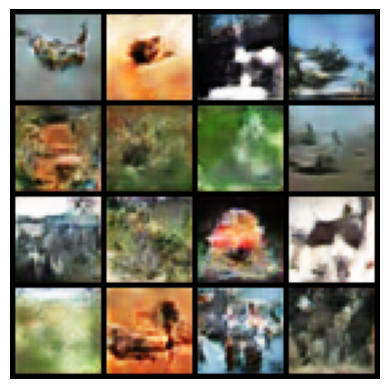

Epoch [2/10]                        Batch 500/1563 Discriminator Loss: 0.9737 Generator Loss: 0.9779
Epoch [2/10]                        Batch 1000/1563 Discriminator Loss: 0.6103 Generator Loss: 1.1970
Epoch [2/10]                        Batch 1500/1563 Discriminator Loss: 0.6867 Generator Loss: 0.6538


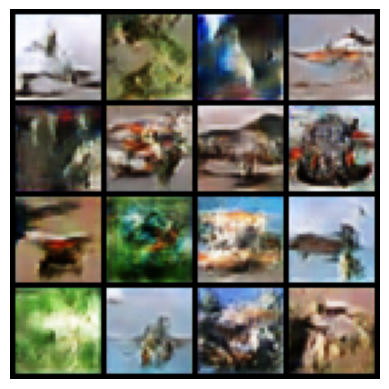

Epoch [3/10]                        Batch 500/1563 Discriminator Loss: 0.4710 Generator Loss: 1.1773
Epoch [3/10]                        Batch 1000/1563 Discriminator Loss: 0.4702 Generator Loss: 1.1241


In [ ]:
# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
       # Convert list to tensor
        real_images = batch[0].to(device)
        # Adversarial ground truths
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)
        # Configure input
        real_images = real_images.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Sample noise as generator input
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        # Generate a batch of images
        fake_images = generator(z)

        # Measure discriminator's ability
        # to classify real and fake images
        real_loss = adversarial_loss(discriminator\
                                     (real_images), valid)
        fake_loss = adversarial_loss(discriminator\
                                     (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        # Backward pass and optimize
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # Generate a batch of images
        gen_images = generator(z)
        # Adversarial loss
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        # Backward pass and optimize
        g_loss.backward()
        optimizer_G.step()
        # ---------------------
        #  Progress Monitoring
        # ---------------------
        if (i + 1) % 500 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    # Save generated images for every epoch
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()